# Remove response

## If first time 

In [ ]:
! pip install wget

## import function

In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as  mpl
import csv
import obspy

import urllib.request as urllib2
import wget

In [6]:
from obspy import read_inventory

def remove_resp(trace, logfile_path, pre_filt = None, output = "VEL", zero_mean=False, water_level=60,plot=False,
                idb = None, ifs = None, iFilter = None, iLC = None) :
    
    '''
    Function to remove the response of minions based on the obspy remove_response function
    
    trace --> obspy trace
    
    logfile_path : path of the logfile - is a string
    pre_filt : prefilter of obspy remove_response function
    output : output parameter of obspy remove_response function - could be 'VEL', 'DISP', 'ACC' or 'DEF'
    zero_mean (bool) : If True, the mean of the waveform data is subtracted in time domain prior to deconvolution.
    water_level (float) : Water level for deconvolution.
    taper (bool) : If True, a cosine taper is applied to the waveform data in time domain prior to deconvolution.
    taper_fraction (float) : Taper fraction of cosine taper to use.
    
    Parameters for the find_response_file function :
    
    idb : force the gain - From 0 to 36 B - is a integer, float or string
    ifs : force the sampling frequency - 50, 100, 125, 250, 500, 1000, 2000 or 4000 Hz - is a integer, float or string
    iFilter : force the Final Filter Phase - could be LP or MP - is a string
    iLC : force the DC Filter - could be 'OFF', '1' or 'DC' - is a string
    
    '''
    
    net = trace.stats.network
    station =  trace.stats.station
    ch =  trace.stats.channel
    loc = trace.stats.location
    
    resp_path = find_response_file(path, idb = idb , ifs = ifs, iFilter = iFilter, iLC = iLC)
    
    modify_resp(resp_path, station, net, ch, loc=loc)
    
    inv = read_inventory('./tmp/tmp.xml')
    
    trace.remove_response(inventory=inv, pre_filt=pre_filt, output=output,
                   water_level=water_level, zero_mean = zero_mean, plot=plot)
    
    return trace

In [7]:
def find_response_file(path, idb = None, ifs = None, iFilter = None, iLC = None) :
    '''
    function to find metadata in the logfile
    
    path : path of the logfile - is a string
    idb : force the gain - From 0 to 36 B - is a integer, float or string
    ifs : force the sampling frequency - 50, 100, 125, 250, 500, 1000, 2000 or 4000 Hz - is a integer, float or string
    iFilter : force the Final Filter Phase - could be LP or MP - is a string
    iLC : force the DC Filter - could be 'OFF', '1' or 'DC' - is a string
    
    '''
    
    
    with open(path) as file :
        readcsv = csv.reader(file, delimiter=' ')
        line = 0
        db = np.zeros(4)
        for row in readcsv :
            #print(row)
            if row != [] :
                if row[0] == 'Project' :
                    pj = row[-1]
                if row[0] == "Serial" :
                    sr = row[-1]
                if row[0] == "Channel" and row[2] == "Gain":
                    c = int(row[1]) - 1
                    db[c] = round(np.exp(0.1155*int(row[-1])))
                if row[0] == "Anti-alias" :
                    if row[-1] == 'Linear' :
                        Filter = 'LP'
                    else :
                        Filter = 'MP'
                if row[0] == "Sample" and row[1] == "Rate" :
                    fs = int(row[-1])
                    if fs == 50 :
                        ch = 'SP'
                    elif fs > 50 and fs <= 125 :
                        ch = 'HP'
                    elif fs >= 250 and fs <= 500 :
                        ch = 'DP'
                    elif fs >= 1000 :
                        ch = 'GP'
                if row[0] == "Low" and row[1] == "Cutter" :
                    if int(row[-1]) == 0 :
                        LC = 'OFF'
                    elif int(row[-1]) == 1 :
                        LC = '1'
                    else :
                        LC = 'DC'
                        
    if idb != None :
        db[0] = round(np.exp(0.1155*int(idb)))
    if ifs != None :
        fs = int(ifs)
    if iFilter != None :
        Filter = str(iFilter)  
    if iLC != None :
        LC = str(iLC)
                        
    name = '%i.%i.%s.%s' %(db[0], fs, Filter, LC)
        
    url = "http://ds.iris.edu/NRL/dataloggers/dtcc/igu16hr3c/"
    page = urllib2.urlopen(url).read()
        
    pp = str(page).split("</td>")
        
    if os.path.exists('./ResponseFile/') == False :
        os.mkdir('./ResponseFile/')
        
        
    for elem in pp :
        if name in elem :
            link = elem.split('"')[1]
    filename = wget.download(url+link, out='./ResponseFile/')
    
    print('File %s downloaded' %link)
    
    return './ResponseFile/'+link

In [8]:
def modify_resp(path, st, net, ch, loc='??') :
    r = csv.reader(open(path), delimiter=' ') # Here your csv file
    lines = list(r)
    
    
    for line in lines :
        if len(line) > 5 :
            if line[5] == 'Station:' :
                line [-1] = st
            if line[5] == 'Network:' :
                line [-1] = net
            if line[5] == 'Channel:' :
                line [-1] = ch
            if line[5] == 'Location:' :
                line [-1] = loc
    
    if os.path.exists('./tmp/') == False :
        os.mkdir('./tmp/')
    
    with open('./tmp/tmp.xml', 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file, delimiter=' ')
        writer.writerows(lines)

## Get metadata information from log file

In [9]:
path = './ExampleData/453001250/20231110162230/DigiSolo.LOG'
find_response_file(path, ifs=1000)

100% [..............................................................................] 20172 / 20172File RESP.XX.DT121..GPZ.SSOLO_IGU16.64.1000.LP.OFF downloaded


'./ResponseFile/RESP.XX.DT121..GPZ.SSOLO_IGU16.64.1000.LP.OFF'

## Remove response

In [14]:
file_path = 'E:/PhD/Supervision/Martin/DATA/chaumont/'
file = '453004444..0.0001.2023.11.10.11.09.45.000.N.miniseed'
st = obspy.read(file_path+file)
trace = st[0]
trace.stats

         network: BE
         station: 04444
        location: BE
         channel: GPN
       starttime: 2023-11-10T11:09:45.000000Z
         endtime: 2023-11-10T12:56:33.000000Z
   sampling_rate: 1000.0
           delta: 0.001
            npts: 6408001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 3749, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 15355904})

100% [..............................................................................] 20172 / 20172File RESP.XX.DT121..GPZ.SSOLO_IGU16.64.1000.LP.OFF downloaded


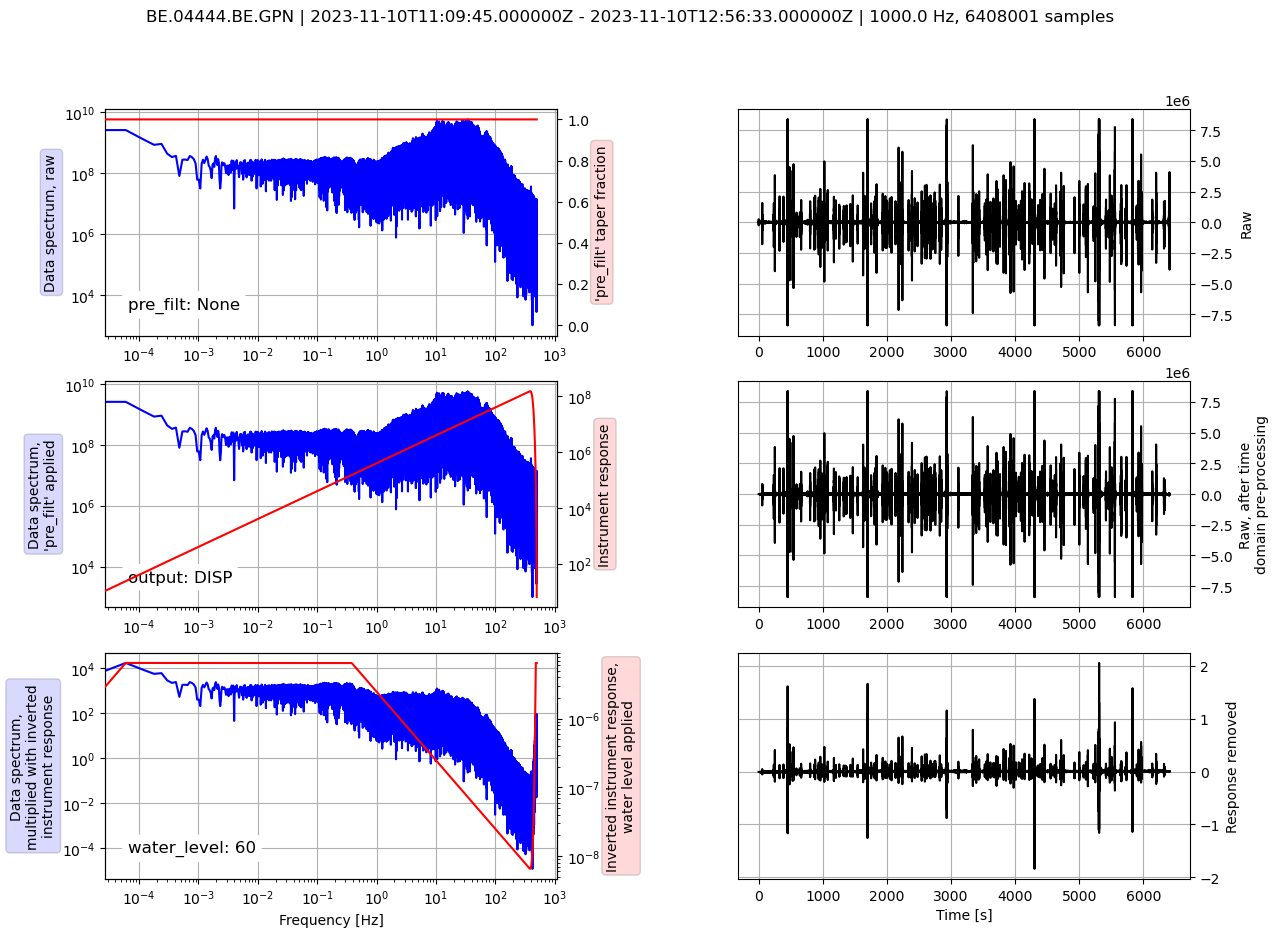

In [12]:
path = 'E:/PhD/Supervision/Martin/DATA/ch_logfile/453004444/20231110141508/DigiSolo.LOG'
rtrace = remove_resp(trace, path, ifs=1000, output='DISP', plot=True)

## Save data with the removed response

In [19]:
output_st = obspy.Stream(rtrace)
output_st.write('./ResponseRemoved/CR_'+file, format="MSEED")